In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-info">
Download and import the Santander dataset. The labels of the test data are not publicly available, so create your own test set by randomly choosing half of the instances in the original training set.</div>

In [2]:
# read the csv input file and convert to Dataframe
path = 'data/santander-customer-transaction-prediction/train.csv'
dataDF = pd.read_csv(path)

# define name of response variable
attrName = dataDF.columns.tolist()[2:]

# split the input data into two parts: training set and validation set
trainDF, valDF = train_test_split(dataDF, test_size=0.5, random_state=42)

Below is the label distribution figure. We can see that the number of samples belong to class '0' is overwhelming the ones in class '1' (nearly 10 times). This indicates that the given dataset is imbalance and causes an negative effect. When applying models onto this dataset, it bias to predict samples belong to class '0'. I will discuss some pre-processing step to eliviate this problem later.

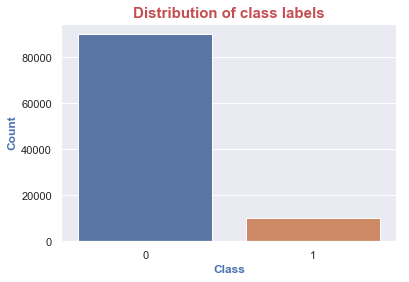

In [3]:
# plot the label distribution
sns.set(style="darkgrid")
ax = sns.countplot(x='target', data=trainDF)
ax.set_xlabel("Class", weight="semibold", color='b', size=12)
ax.set_ylabel("Count", weight="semibold", color='b', size=12)
ax.set_title("Distribution of class labels", weight="semibold", color='r', size=15)
plt.show()

In [4]:
print('The number of attributes in the given dataset is', len(attrName))

The number of attributes in the given dataset is 200


As we can see, the number of attributes in the given dataset is 200. When applying models in which their math fomulas related to exponential, it is really important to take care the intial coefficients since the function value grow exponentially. However, with a high dimensional dataset, choosing an appropriate is not easy. A bad intial setting can cause "MemoryError' when implement (the value is huge) or applying optimization methods is harder to converge (bad learning rate).

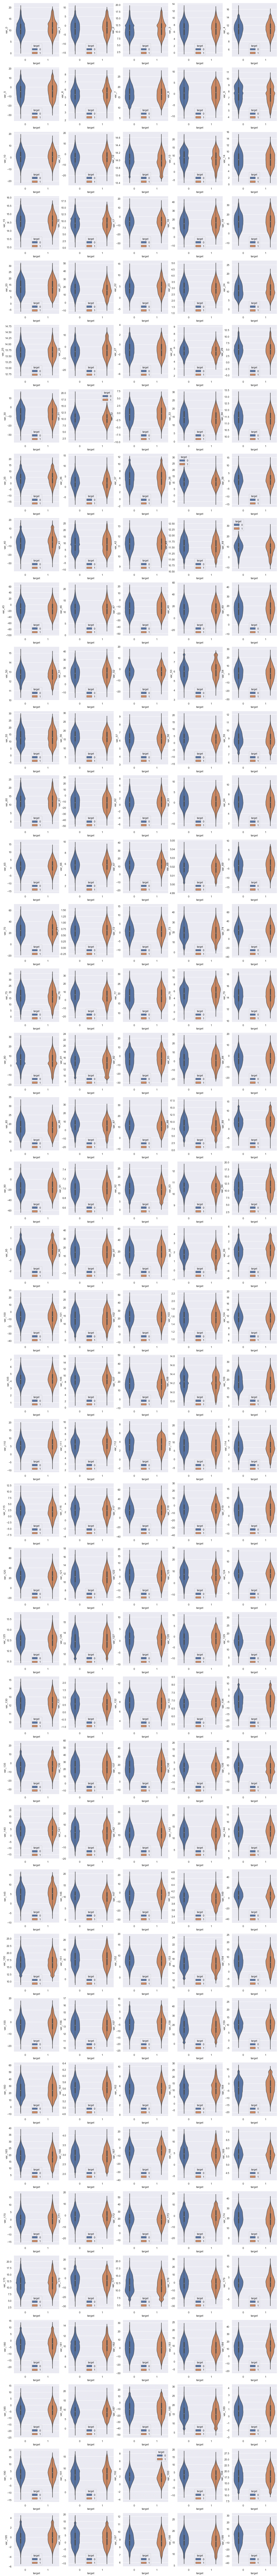

In [5]:
# plot the distribution for each feature
nbCols = 5
nbRows = len(attrName)//nbCols
fig, ax = plt.subplots(nbRows, nbCols, figsize=(20,200))
for i in range(len(attrName)):
    sns.violinplot(data=dataDF, x='target', y=attrName[i], hue='target', ax=ax[i//nbCols][i%nbCols])

In [6]:
# split training set into 2 parts: input variables and target
Xtrain = trainDF[attrName].values
ytrain = trainDF.target.values

# do the same with validation set
Xval = valDF[attrName].values
yval = valDF.target.values

In [7]:
# up-sampling the original datatset
SmoteUp = SMOTE(k_neighbors=5)
features_resampling, target_resampling = SmoteUp.fit_sample(Xtrain, ytrain)
Xtrain = features_resampling
ytrain = target_resampling

<div class="alert alert-info">
Implement Bayesian linear regression.</div>

In [8]:
class BayesianLinearRegression(object):
    
    """Bayesian Linear Regression.

    This class implements Bayesian version of linear regression. 
    
    Input with defined prior distribution over parameter, it updates
    
    the posterior distribution by the given dataset."""
    
    def __init__(self, e_v, p_v):
        
        """Intialization.
        
        Parameters
        ----------
        e_v: float, optional
        
            The variance of the Gaussian noise in linear regression


        p_v: {array-like, sparse matrix}, shape (n_features, n_features)
        
            The covariance of prior, where n_features is the number of features.

            
        Attributes
        ----------

        pos_m : array, shape (n_features, )

            The mean of posterior.
            
        pos_v : {array-like, sparse matrix}, shape (n_features, n_features)
    
            The covariance of posterior.

        """

        self.e_v = e_v
        self.p_v = p_v
        
    def fit(self, X, t):
        
        """Fit the model according to the given training data.


        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)

            Training vector, where n_samples is the number of samples and

            n_features is the number of features.


        t : array-like, shape (n_samples,)

            Target vector relative to X.



        Returns
        -------
        
        self : object

        """
            
        self.pos_v = inv((np.dot(X.T, X)/(self.e_v) + inv(self.p_v)))
        self.pos_m = np.dot(self.pos_v, np.dot(X.T, t))/(self.e_v)
        
        return self

    def predict(self, X):
        
        """predict using the Bayesian linear regression model
        

        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]


        Returns
        -------

        ynew : array-like, shape = [n_samples,]

            Returns the predicted value of the input sample.

        ynew_v : array-like, shape = [n_samples,]

            Returns the predicted value's variance of the input sample.
        """
        
        ynew = np.dot(X, self.pos_m)
        ynew_v = []
        
        for x in X:
            ynew_v.append(self.e_v + np.dot(np.dot(x.T, self.pos_v), x))
        
        return np.array(ynew), np.array(ynew_v)

<div class="alert alert-info">
Write code that calculates the N-th order polynomial transformation of the input data.</div>

In [9]:
def polynomialTransform(X, n):
    
    """predict using the Bayesian linear regression model
        

    Parameters
    ----------
    X : array-like, shape = [n_samples, n_features]
        
        Input data, where n_samples is the number of samples and
        
        n_features is the number of features.

    
    Returns
    -------

    X_ : array-like, shape = [n_samples, n_features*n]

         Returns the N-th order polynomial transformation of the input data.

    """
        
    X_ = X
    for i in range(2, (n+1)):
        X_ = np.column_stack((X_, X**i))
    
    return X_

<div class="alert alert-info">
Treat class labels as continuous and apply regression to the training data. Also, calculate the posterior variance of the weights.</div>

In [10]:
# prior distribution and noise setting
prior_variance = 1e20*np.eye(len(attrName))
error_variance = 0.01

# apply Bayesian linear regression on training data
model = BayesianLinearRegression(error_variance, prior_variance)
model.fit(Xtrain, ytrain)

pred, predVariance = model.predict(Xval)
predLabel = [1 if p>0.5 else 0 for p in pred]

Below is the estimated parameters along with variance

In [11]:
# mean of the estimated parameters
model.pos_m

array([ 1.00186423e-02,  6.45490238e-03,  1.10620999e-02,  2.27354102e-03,
        4.03538214e-03,  2.38020328e-03,  4.91679843e-02, -4.36591914e-04,
        3.09409227e-03, -1.82336971e-02,  4.74841407e-04,  2.34599477e-03,
       -1.75964069e-01, -6.21828226e-03, -1.17629498e-03,  2.68210134e-02,
       -4.10068810e-04, -1.51956897e-04,  2.79385722e-03,  7.79780622e-04,
       -1.69664118e-03, -4.08756042e-03,  1.14697848e-02, -2.06340246e-02,
        4.54214728e-03,  4.35780650e-02,  5.01431970e-03, -1.51248872e-03,
       -1.40789861e-02,  4.87811709e-06, -3.89801509e-04, -7.72651635e-03,
        7.96638701e-03, -5.55404226e-03, -5.08842878e-02,  3.70293477e-03,
       -8.34949912e-03,  2.65482953e-03,  3.70411252e-05, -7.49019052e-04,
        3.54609163e-03, -8.73629835e-04, -9.23646569e-03, -3.21485230e-02,
       -4.36053606e-03, -5.08715204e-04,  9.55244203e-05,  3.86484957e-04,
        1.43182491e-03,  2.00836242e-03, -1.06630569e-02,  1.81039151e-03,
        3.09709427e-03,  

In [12]:
# variance of the estimated parameters
model.pos_v

array([[ 6.69713979e-09, -4.69020707e-11, -5.06194375e-11, ...,
         2.36759475e-10,  6.66413703e-12, -1.41849351e-11],
       [-4.69020707e-11,  3.84288300e-09, -6.71830612e-11, ...,
         1.51546307e-10,  7.84512076e-11, -6.36615538e-12],
       [-5.06194375e-11, -6.71830612e-11,  8.87482652e-09, ...,
         4.85414093e-11,  7.20520117e-11, -1.05092271e-11],
       ...,
       [ 2.36759475e-10,  1.51546307e-10,  4.85414093e-11, ...,
         7.66816901e-08, -1.18385173e-10, -6.34583303e-11],
       [ 6.66413703e-12,  7.84512076e-11,  7.20520117e-11, ...,
        -1.18385173e-10,  6.83104335e-09,  9.89249252e-12],
       [-1.41849351e-11, -6.36615538e-12, -1.05092271e-11, ...,
        -6.34583303e-11,  9.89249252e-12,  5.75345815e-10]])

In [13]:
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):

    """Plot the confusion matrix.
        

    Parameters
    ----------
    ytrue : array-like, shape = [n_samples, ]
        
        The true value , where n_samples is the number of samples.

    ypred : array-like, shape = [n_samples, ]
        
        The predicted value

    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalize = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)

    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    ax[0].imshow(cm, interpolation='nearest', cmap=cmap)
    ax[1].imshow(cm_normalize, interpolation='nearest', cmap=cmap)
    
    # Show all ticks
    ax[0].set_xlabel("Predicted label", weight="semibold", color='b', size=15)
    ax[0].set_ylabel("True label", weight="semibold", color='b', size=15)
    ax[0].set_title("Confusion matrix, without normalization", weight="semibold", color='r', size=15)
    ax[0].set_xticks(classes)
    ax[0].set_yticks(classes)
    
    ax[1].set_xlabel("Predicted label", weight="semibold", color='b', size=15)
    ax[1].set_ylabel("True label", weight="semibold", color='b', size=15)
    ax[1].set_title("Confusion matrix, with normalization", weight="semibold", color='r', size=15)
    ax[1].set_xticks(classes)
    ax[1].set_yticks(classes)

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax[0].text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="r", fontsize=30, weight="semibold")
            ax[1].text(j, i, format(cm_normalize[i, j], '.2f'), ha="center", va="center", color="r", fontsize=30, weight="semibold")

    fig.tight_layout()

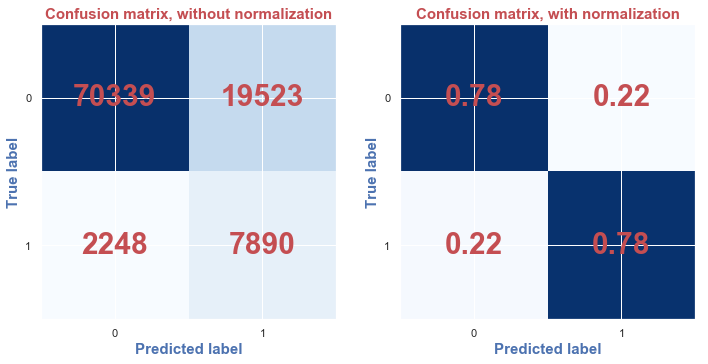

In [14]:
# Plot confusion matrix
plot_confusion_matrix(yval, predLabel)
plt.show()

In [15]:
print('F1 score on the validation set is', f1_score(predLabel, yval, average='macro'))

F1 score on the validation set is 0.6431055218897093


In [16]:
rdnPredLabel = np.random.randint(2, size=len(yval))
print('F1 score on the validation set with random prediction is', f1_score(rdnPredLabel, yval, average='macro'))

F1 score on the validation set with random prediction is 0.4055367404703351


## Logistic Regression

<div class="alert alert-info">
Implement a logistic regression classifier that optimizes for the Maximum a Posteriori (MAP) estimate; assume a Gaussian prior on the parameters.</div>

<div class="alert alert-info">
Write a function that calculates the gradient of the joint likelihood.</div> 

#### COMMENT: 
For the question, I wrote two functions that compute the gradient and Hessian matrix for the log join likelihood. The reason is since we implement two optimization methods for the given problem: one using the gradient and other using the Hessian matrix.

In [32]:
def logJoinLikelihood_grad(X, t, w, p_m, p_v):
    
    """Computes the gradient of the log join likelihood.


    Parameters
    ----------

    X : {array-like, sparse matrix}, shape (n_samples, n_features)

        Training data, where n_samples is the number of samples and

        n_features is the number of features.


    t : ndarray, shape (n_samples,)

        Array of labels.

    w : ndarray, shape (n_features,)

        Coefficient vector.


    p_m: array-like, shape (n_features, )
        
        The mean of prior.


    p_v: {array-like, sparse matrix}, shape (n_features, n_features)
        
        The covariance of prior.


    Returns
    -------

    grad : ndarray, shape (n_features,)

        Log join likelihood gradient.


    Reference
    ---------

    """
        
    p = 1/(1 + np.exp(-X.dot(w)))
    grad = (X.T.dot(t-p) + inv(p_v).dot(w-p_m))

    return grad

In [33]:
def logJoinLikelihood_hess(X, t, w, p_m, p_v):
        
    """Computes the Hessian of the log join likelihood.


    Parameters
    ----------

    X : {array-like, sparse matrix}, shape (n_samples, n_features)

        Training data, where n_samples is the number of samples and

        n_features is the number of features.


    t : ndarray, shape (n_samples,)

        Array of labels.

    w : ndarray, shape (n_features,)

        Coefficient vector.


    p_m : array-like, shape (n_features, )
        
        The mean of prior.


    p_v : {array-like, sparse matrix}, shape (n_features, n_features)
        
        The covariance of prior.



    Returns
    -------

    hess : {array-like, sparse matrix}, shape (n_features, n_features)

        The Hessian matrix


    Reference
    ---------
      
    Bishop, C. M. (2006). Pattern recognition and machine learning.

    Springer. (Chapter 4.5.1)
    
    """

    p = 1/(1 + np.exp(-X.dot(w)))
    hess = ((X.T*(p*(1-p))).dot(X) + inv(p_v))

    return hess

<div class="alert alert-info">
Write a simple gradient descend algorithm that uses the gradients calculated by the function of previous question to converge to the MAP estimate.</div> 

#### COMMENT: 
For the question, I wrote three below functions. The first is a helper function to compute the value of log join likelihood with  specified coefficients. The second is to implement gradient descent method to find the coefficient maximizing the log join likelihood. The last is Newton-Raphson version of given optimization problem.

In [34]:
def logJoinLikelihood(X, t, w, p_m, p_v):
        
    """Computes the value of the log join likelihood fucntion.


    Parameters
    ----------

    X : {array-like, sparse matrix}, shape (n_samples, n_features)

        Training data, where n_samples is the number of samples and

        n_features is the number of features.


    t : ndarray, shape (n_samples,)

        Array of labels.

    w : ndarray, shape (n_features,)

        Coefficient vector.


    p_m: array-like, shape (n_features, )
        
        The mean of prior.


    p_v: {array-like, sparse matrix}, shape (n_features, n_features)
        
        The covariance of prior.


    Returns
    -------

    logJoinLikelihood : float, optional

        The value of the log join likelihood fucntion.


    Reference
    ---------

    Bishop, C. M. (2006). Pattern recognition and machine learning.

    Springer. (Chapter 4.5.1)
    
    """

    p = 1/(1+np.exp(-X.dot(w)))
    loglikelihood = np.sum((t * np.log(p) + (1 - t) * np.log(1 - p)))
    logPrior = np.log(multivariate_normal.pdf(w, p_m, p_v))

    logJoinLikelihood = loglikelihood + logPrior
    
    return logJoinLikelihood

In [35]:
def GradientDescent(X, t, w, p_m, p_v, eta, tol, max_iter):
      
    """Implement gradient descent method to find optimal point for the maximize 
    
    log join likelihood. This method is extended by using backtracking line search
    
    version to make sure each step will improve objective function.


    Parameters
    ----------

    X : {array-like, sparse matrix}, shape (n_samples, n_features)

        Training data, where n_samples is the number of samples and

        n_features is the number of features.


    t : ndarray, shape (n_samples,)

        Array of labels.


    w : ndarray, shape (n_features,)

        Coefficient vector.


    p_m: array-like, shape (n_features, )
        
        The mean of prior.


    p_v: {array-like, sparse matrix}, shape (n_features, n_features)
        
        The covariance of prior.


    eta: float, optional
        
        The learning rate


    tol : float, optional
        
        Tolerance for stopping criteria.


    max_iter: int, optional
        
        Maximum number of iterations taken for the solvers to converge.



    Returns

    -------

    w_opt: ndarray, shape (n_features,)

        The optimal coefficient vector.
        
    losses: ndarray, optimal
    
        Values of the objective function, saving for each iteration.

    
    Reference
    ---------

    Stephen Boyd and Lieven Vandenberghe (2004). Convex Optimization.

    Cambridge. (Chapter 9.3)
    
    """
    
    # hyper-parameters setting
    alpha = 0.5
    beta = 0.5
    losses = []
    w_opt = 0

    for i in range(max_iter):
            
        # using backtracking line search to find the next step length.
        eta_p = eta
        grad = logJoinLikelihood_grad(X, t, w, p_m, p_v)
        loss = logJoinLikelihood(X, t, w, p_m, p_v)
        while (logJoinLikelihood(X, t, (w + eta_p * grad), p_m, p_v) < loss + alpha * eta_p * (grad**2).sum()):
            eta_p *= beta

        # update the coefficient for next step 
        w_new = w + eta_p*grad
            
        # check convergence
        loss_new = logJoinLikelihood(X, t, w_new, p_m, p_v)
        if (abs(loss_new - loss) < tol):
            break
        else:
            losses.append(loss_new)
            loss, w = loss_new, w_new
                
    w_opt = w_new
    return w_opt, np.array(losses)

In [36]:
def NewtonRaphson(X, t, w, p_m, p_v, eta, tol, max_iter):
    

    """Implement gradient descent method to to find optimal point
    
    for the maximize log join likelihood.


    Parameters
    ----------

    X : {array-like, sparse matrix}, shape (n_samples, n_features)

        Training data, where n_samples is the number of samples and

        n_features is the number of features.


    t : ndarray, shape (n_samples,)

        Array of labels.


    w : ndarray, shape (n_features,)

        Coefficient vector.


    p_m: array-like, shape (n_features, )
        
        The mean of prior.


    p_v: {array-like, sparse matrix}, shape (n_features, n_features)
        
        The covariance of prior.


    eta: float, optional
        
        The learning rate


    tol : float, optional
        
        Tolerance for stopping criteria.


    max_iter: int, optional
        
        Maximum number of iterations taken for the solvers to converge.



    Returns

    -------

    w_opt: ndarray, shape (n_features,)

        The optimal coefficient vector.
        
    losses: ndarray, optional
    
        Values of the objective function, saving for each iteration.
        
    Reference
    ---------

    Stephen Boyd and Lieven Vandenberghe (2004). Convex Optimization.

    Cambridge. (Chapter 9.5)

    """

    # hyper-parameters setting (Note: 'loss' is set to large value to avoid first time stop)
    loss = 1e5
    losses = []
    w_opt = 0
    
    for i in range(max_iter):
             
        # find the next step length.
        grad = logJoinLikelihood_grad(X, t, w, p_m, p_v)
        hess = logJoinLikelihood_hess(X, t, w, p_m, p_v)
            
        # update the coefficient for next step 
        w_new = w + eta * inv(hess).dot(grad)
        
        # check convergence
        loss_new = logJoinLikelihood(X, t, w_new, p_m, p_v)
        if (abs(loss_new - loss) < tol):
            break
        else:
            losses.append(loss_new)
            loss, w = loss_new, w_new
            
        w_opt = w_new
    
    return w_opt, losses

<div class="alert alert-info">
Implement a package to solve given problem by Bayesian logistic regression using above helper functions</div> 

In [37]:
class BayesianLogistic(object):
    
    
    """Bayesian Logistic Regression classifier.

    This class implements Bayesian version of logistic regression. 
    
    Input with defined prior distribution over parameter, it updates
    
    the posterior distribution by the given dataset. Moreover, the posterior
    
    is updated by using two methods: point estimate (MAP) and Laplace approximation. 
    
    The former is optimized by gradient descent or Newton-Raphson techiniques."""

    
    def __init__(self, p_m, p_v, solver='newton', eta=1e-3, tol=1e-5, max_iter=100):
        
        """Intialization.
        
        Parameters
        ----------
        p_m: array-like, shape (n_features, )
        
            The mean of prior, where n_features is the number of features.


        p_v: {array-like, sparse matrix}, shape (n_features, n_features)
        
            The covariance of prior, where n_features is the number of features.
        
        
        solver : str, {'newton', 'gd'}, optional (default='newton').
        
        Algorithm to use in the optimization problem.

        - 'newton' implement Newton-Raphson method, fast converge but need more computation (Hessian matrix)

        - 'gd' implement gradient descent method
            
            
        eta: float, optional (default=1e-3)
        
            The learning rate


        tol : float, optional (default=1e-5)
        
            Tolerance for stopping criteria.


        max_iter: int, optional (default=100)
        
            Maximum number of iterations taken for the solvers to converge.

            
        Attributes
        ----------

        coef_ : array, shape (1, n_features)

            Coefficient of the features in the decision function when using MAP estimate.
            
        losses_ : ndarray, optional
    
            Values of the objective function, saving for each iteration.

        """
        self.p_m = p_m
        self.p_v = p_v
        self.solver = solver
        self.eta = eta
        self.tol = tol
        self.max_iter = max_iter
        

    def fit(self, X, t):
        
        
        """Fit the model according to the given training data.


        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)

            Training vector, where n_samples is the number of samples and

            n_features is the number of features.


        t : array-like, shape (n_samples,)

            Target vector relative to X.



        Returns
        -------
        
        self : object


        """
        
        w_init = 1e-3*np.ones(X.shape[1])

        if (self.solver == 'gd'):
            self.coef_, self.losses_ = GradientDescent(X, t, w_init, self.p_m, self.p_v, self.eta, self.tol, self.max_iter)
        else:
            self.coef_, self.losses_ = NewtonRaphson(X, t, w_init, self.p_m, self.p_v, self.eta, self.tol, self.max_iter)
    
        return self
    
    
    def predict(self, X):
            
        """predict using the logistic model
        

        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]


        Returns
        -------

        T : array-like, shape = [n_samples,]

            Returns the class of the sample.

        """
        
        pred = []
        
        for p in 1/(1+np.exp(-X.dot(self.coef_))):
            if p <= 0.5:
                pred.append(0)
            else:
                pred.append(1)
        
        return np.array(pred)

Apply Bayesian logistic regression on the training data

In [38]:
# prior distribution setting
prior_variance = 1e2*np.eye(len(attrName))
prior_mean = np.zeros(len(attrName))

# apply Bayesian logistic regression on training data (Newton-Raphson method)
model = BayesianLogistic(p_m=prior_mean, p_v=prior_variance, solver='newton', eta=5e-1, max_iter=100)
model.fit(Xtrain, ytrain)
pred = model.predict(Xval)

Plot the path the gradient takes from its initial to its final position

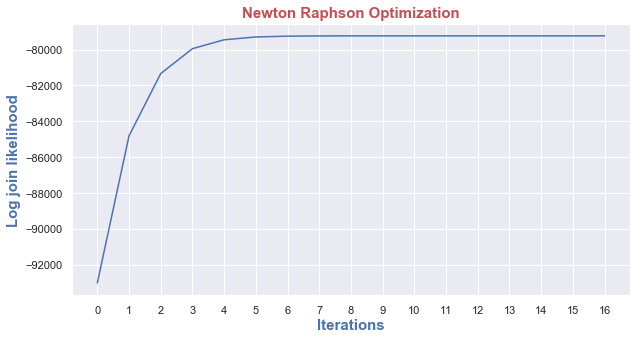

In [39]:
plt.figure(figsize=(10,5))
plt.plot(range(len(model.losses_)), np.array(model.losses_))
plt.xlabel("Iterations", weight="semibold", color='b', size=15)
plt.ylabel("Log join likelihood", weight="semibold", color='b', size=15)
plt.xticks(range(len(model.losses_)))
plt.title("Newton Raphson Optimization", weight="semibold", color='r', size=15)
plt.show()

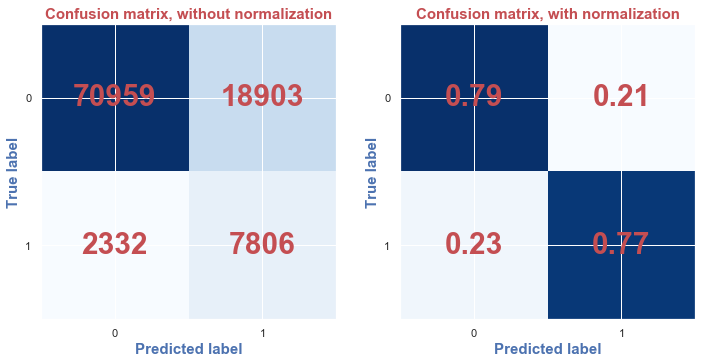

In [40]:
# Plot confusion matrix
plot_confusion_matrix(yval, pred)
plt.show()

In [41]:
print('F1 score on the validation set is', f1_score(pred, yval, average='macro'))

F1 score on the validation set is 0.6467720448960879


In [42]:
from sklearn.metrics import accuracy_score 
accuracy_score(pred, yval)

0.78765

<div class="alert alert-info">
Implement Laplace approximation</div> 

In [43]:
class BayesianLogistic_LaplaceApproximation(BayesianLogistic):
    
    
    """Bayesian Logistic Regression classifier.

    This class inherit BayesianLogistic class. Futhermore, it is extend by  
    
    apply Laplace approximation to find a Gaussian approximation to a posterior distribution"""

    def LaplaceApproximation(self, X, t):

        """predict using the logistic model
        

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)

            Training vector, where n_samples is the number of samples and

            n_features is the number of features.


        t : array-like, shape (n_samples,)

            Target vector relative to X.
            

        Returns
        -------

        self : object

        """
            
        w_init = 1e-3*np.ones(X.shape[1])
        self.pos_m, _ = NewtonRaphson(X, t, w_init, self.p_m, self.p_v, self.eta, self.tol, self.max_iter)
        self.pos_v = inv(-logJoinLikelihood_hess(X, t, self.pos_m, self.p_m, self.p_v))

        return self

In [44]:
# prior distribution setting
prior_variance = 1e2*np.eye(len(attrName))
prior_mean = np.zeros(len(attrName))

# apply Bayesian logistic regression on training data
model = BayesianLogistic_LaplaceApproximation(p_m=prior_mean, p_v=prior_variance, eta=1e-2, max_iter=10)
model = model.LaplaceApproximation(Xtrain, ytrain)

In [45]:
# mean of Laplace approximation distribution
model.pos_m

array([ 6.22312427e-03,  4.29932689e-03,  6.79355463e-03,  2.07329509e-03,
        3.04740427e-03,  2.11557539e-03,  2.71156061e-02,  5.86926209e-04,
        2.45894775e-03, -8.95686703e-03,  1.08574942e-03,  2.06351328e-03,
       -9.49372726e-02, -2.57702173e-03,  1.42892366e-04,  1.52478400e-02,
        6.01250892e-04,  7.52626187e-04,  2.34028510e-03,  1.23789422e-03,
       -9.95032970e-05, -1.37767983e-03,  7.02075635e-03, -1.01823892e-02,
        3.25489951e-03,  2.41559377e-02,  3.55441131e-03,  3.73180349e-06,
       -6.78165296e-03,  8.32716104e-04,  6.11947019e-04, -3.34126548e-03,
        5.05331145e-03, -2.15465993e-03, -2.65472227e-02,  2.82851070e-03,
       -3.65723625e-03,  2.24365704e-03,  8.43860132e-04,  3.99610878e-04,
        2.72269748e-03,  3.70852877e-04, -4.16740874e-03, -1.66697516e-02,
       -1.54067426e-03,  5.46697555e-04,  9.40416244e-04,  1.02889936e-03,
        1.60076548e-03,  1.89207034e-03, -4.82128327e-03,  1.80265131e-03,
        2.48723400e-03,  

In [46]:
# variance of Laplace approximation distribution
model.pos_v

array([[-3.75168939e-06,  2.32612811e-08,  2.68478047e-08, ...,
        -1.26297616e-07, -7.92304240e-09,  7.12303327e-09],
       [ 2.32612811e-08, -2.14282873e-06,  3.56951121e-08, ...,
        -8.59011590e-08, -4.30760561e-08,  3.68181709e-09],
       [ 2.68478047e-08,  3.56951121e-08, -4.96864881e-06, ...,
        -2.37809946e-08, -3.63615397e-08,  6.19724512e-09],
       ...,
       [-1.26297616e-07, -8.59011590e-08, -2.37809946e-08, ...,
        -4.26804989e-05,  6.29521562e-08,  3.36970591e-08],
       [-7.92304240e-09, -4.30760561e-08, -3.63615397e-08, ...,
         6.29521562e-08, -3.81847098e-06, -5.11393757e-09],
       [ 7.12303327e-09,  3.68181709e-09,  6.19724512e-09, ...,
         3.36970591e-08, -5.11393757e-09, -3.20432761e-07]])

#### COMMENT:

The output of Laplace approximation is a Gaussian distribution approximate the posterior distribution of given problem $ q(w) \sim N(w \mid w_{MAP}, S_N)$, where:
$w_{MAP}$ is the maximum posterior (pos_m) and $S_N^{-1}$ is Hessian matrix of posterior at $w = w_{MAP}$ (pos_v)